Reading /home/user/Projects/FingerMovementDecoder/dirty_field/../Source/Subjects/Ga_Fed_06/Epochs/RespCor_LM_B1_epochs.fif ...
    Found the data of interest:
        t =    -500.00 ...     500.00 ms
        0 CTF compensation matrices available
Not setting metadata
Not setting metadata


/tmp/ipykernel_23373/3361990237.py:24: RuntimeWarning: This filename (../Source/Subjects/Ga_Fed_06/Epochs/RespCor_LM_B1_epochs.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  resp_lock_lm_B1_epochs = mne.read_epochs(resp_lock_lm_B1_epochs_path)


58 matching events found
No baseline correction applied
0 projection items activated
No baseline correction applied


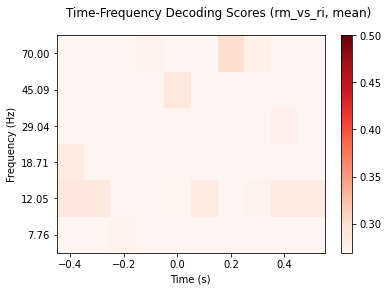

In [2]:
import sys
import os
current_dir = os.path.dirname(os.path.abspath('./'))
if not current_dir in sys.path:
    sys.path.append(current_dir)

from typing import Iterable, Union
from cross_runs_TF_planes import CrossRunsTFScorer
import os
from matplotlib.backends._backend_tk import NavigationToolbar2Tk
from matplotlib.backends.backend_tkagg import FigureCanvasTkAgg
from utils.data_management import dict2str
import re
import PySimpleGUI as sg
import pickle
import mne
from utils.structures import Linked

content_root = '../'
subjects_folder_path = os.path.join(content_root, 'Source/Subjects')
subject_path = os.path.join(subjects_folder_path, 'Ga_Fed_06')
raw_path = os.path.join(subject_path, 'Raw', 'ML_Subject05_P1_tsss_mc_trans.fif')
resp_lock_lm_B1_epochs_path = os.path.join(subject_path, 'Epochs', 'RespCor_LM_B1_epochs.fif')
resp_lock_lm_B1_epochs = mne.read_epochs(resp_lock_lm_B1_epochs_path)


from matplotlib import pyplot as plt
from mne.time_frequency import AverageTFR
from mne import create_info
import numpy as np

def format_ranges(unformatted_ranges: Iterable) -> tuple[str, dict[str, str]]:

    ranges = list()

    for range_ in unformatted_ranges:
        expr1 = r'.*\d-'
        find1 = re.findall(expr1, range_)[0][:-1]
        expr2 = r'(\d--\d.*)|(\d-\d.*)'
        res = re.findall(expr2, range_)[0]
        find2 = res[0][2:] if res[0] != '' else res[1][2:]
        ranges.append(f'{float(find1) :.2f} - {float(find2) :.2f}')

    return ranges, {range_: urange for range_, urange in zip(ranges, unformatted_ranges)}

class Toolbar(NavigationToolbar2Tk):
    def __init__(self, *args, **kwargs):
        super(Toolbar, self).__init__(*args, **kwargs)

def draw_figure_w_toolbar(canvas, fig, canvas_toolbar):
    if canvas.children:
        for child in canvas.winfo_children():
            child.destroy()
    if canvas_toolbar.children:
        for child in canvas_toolbar.winfo_children():
            child.destroy()
    figure_canvas_agg = FigureCanvasTkAgg(fig, master=canvas)
    figure_canvas_agg.draw()
    toolbar = Toolbar(figure_canvas_agg, canvas_toolbar)
    toolbar.update()
    figure_canvas_agg.get_tk_widget().pack(side='right', fill='both', expand=1)

def clean_canvas(canvas, canvas_toolbar):
    if canvas.children:
        for child in canvas.winfo_children():
            child.destroy()
    if canvas_toolbar.children:
        for child in canvas_toolbar.winfo_children():
            child.destroy()


def generate_sessions(subject_link: Linked) -> Union[list, None]:
    if subject_link is not None:
        subject_link.meta.update({
            'path': os.path.join(root, subject_link.selected_option, 'TF_planes')
        })
        return sorted([session for session in os.listdir(subject_link.meta['path'])])
    else:
        return None

def generate_locks(session_link: Linked) -> Union[list, None]:
    if session_link.selected_option is not None:
        session_link.meta.update({
            'path': os.path.join(session_link.parent.meta['path'], session_link.selected_option)
        })
        return sorted([
            lock for lock in os.listdir(session_link.meta['path'])
        ])
    else:
        return None

def generate_cases(locks_link: Linked) -> Union[list, None]:
    if locks_link.selected_option is not None:
        locks_link.meta.update({
            'path': os.path.join(locks_link.parent.meta['path'], locks_link.selected_option),
        })
        return sorted([
            case[:-4] for case in os.listdir(locks_link.meta['path'])
        ])
    else:
        return None

def generate_freqs(case_link: Linked) -> Union[list, None]:
    if case_link.selected_option is not None:
        path = os.path.join(case_link.parent.meta["path"], f'{case_link.selected_option}.pkl')
        tfs = pickle.load(open(path, 'rb'))
        freqs, freqmap = format_ranges(list(tfs.csp.keys()))
        case_link.meta.update({
            'path': path,
            'tfs': tfs,
            'freqmap': freqmap
        })
        return freqs
    else:
        return None


def generate_times(freqs_link: Linked) -> Union[list, None]:
    if freqs_link.selected_option is not None:
        times, timemap = format_ranges(
            list(
                freqs_link.parent.meta['tfs'].csp[
                    freqs_link.parent.meta['freqmap'][freqs_link.selected_option]
                ].keys()
            )
        )
        freqs_link.meta.update({
            'path': freqs_link.parent.meta['path'],
            'timemap': timemap
        })
        return times
    else:
        return None

root = '../Source/Subjects'
chain = Linked(
    name='SubjectsSelector',
    children=Linked(
        name='SessionSelector',
        children=Linked(
            name='LockSelector',
            children=Linked(
                name='CaseSelector',
                children=Linked(
                    name='FrequencySelector',
                    children=Linked(
                        name='TimeSelector'
                    )
                )
            )
        )
    )
)

# def inverse_dependencies(self):
#         if self.children is None:
#             return []
#         elif isinstance(self.children, list) and self.children:
#             invdep = [child for child in self.children]
#             for child in invdep:
#                 invdep += [
#                     dep for dep in
#                     inverse_dependencies(child)
#                     if dep not in invdep
#                 ]
#             return invdep
#         elif issubclass(type(self.children), Linked):
#             return [self.children]

subjects, sessions, locks, cases, freqs, times = (link for link in chain)

subjects.child_options_generator = generate_sessions
sessions.child_options_generator = generate_locks
locks.child_options_generator = generate_cases
cases.child_options_generator = generate_freqs
freqs.child_options_generator = generate_times

options = [subject_name for subject_name in os.listdir(root)]
chain(options)


sg.theme('DarkGrey5')
layout = [
    [sg.T('Time-Frequency Decoding', font='ANY 15')],
    [sg.Column([
        [
            sg.Text('Subject:', font='ANY 12'),
            sg.Combo(
                values=subjects.options,
                default_value=subjects.selected_option,
                size=(15, 1),
                enable_events=True,
                key='select_subject',
                font='ANY 12',
                background_color='#eeeeee',
                readonly=True
            ),
            sg.Text('Session:', font='ANY 12', pad=((58, 5), 0)),
            sg.Combo(
                values=sessions.options,
                default_value=sessions.selected_option,
                size=(15, 1),
                enable_events=True,
                key='select_session',
                font='ANY 12',
                background_color='#eeeeee',
                readonly=True
            ),
            sg.Text('Lock:', font='ANY 12', pad=((45, 5), 0)),
            sg.Combo(
                values=locks.options,
                default_value=locks.selected_option,
                size=(15, 1),
                enable_events=True,
                key='select_lock',
                font='ANY 12',
                background_color='#eeeeee',
                readonly=True
            ),
        ]
    ], pad=(100, 0))],
    [sg.Column([
        [
            sg.Text('Case:', font='ANY 12', pad=((21, 5), 0)),
            sg.Combo(
                values=cases.options,
                default_value=cases.selected_option,
                size=(15, 1),
                enable_events=True,
                key='select_case',
                font='ANY 12',
                background_color='#eeeeee',
                readonly=True
            ),
            sg.Text('Frequency (Hz):', font='ANY 12'),
            sg.Combo(
                values=freqs.options,
                default_value=freqs.selected_option,
                size=(15, 1),
                enable_events=True,
                key='select_frequency',
                font='ANY 12',
                background_color='#eeeeee',
                readonly=True
            ),
            sg.Text('Time (sec):', font='ANY 12'),
            sg.Combo(
                values=times.options,
                default_value=times.selected_option,
                size=(15, 1),
                enable_events=True,
                key='select_time',
                font='ANY 12',
                background_color='#eeeeee',
                readonly=True
            ),
            sg.B('Plot TF-plane', key='-plot-plane-', pad=(15, 5), font='ANY 12'),
        ]
    ], pad=(100, 0))],
    [sg.Text(
        f'Time to accuracy and standard deviation at {freqs.selected_option} Hz',
        font='ANY 12', key='textbox-description',
        pad = (10, (10, 0))
    )],
    [sg.Multiline(
        size=(28, 5),
        key='textbox',
        background_color='#555555',
        disabled=True,
        text_color='#eeeeee',
        font='ANY 12',
        default_text='             Time         Acc         StD' + dict2str({
            time: f'  {acc :.2f},   {std :.4f}'
         for time, acc, std in zip(
                freqs.meta['timemap'].keys(),
                cases.meta['tfs'].tf_windows_mean()[cases.meta['freqmap'][freqs.selected_option]].values(),
                cases.meta['tfs'].tf_windows_std()[cases.meta['freqmap'][freqs.selected_option]].values(),
            )
        }, space=6, tabulation=0)[1:-2],
        pad=(110, 10)
    )],
    [sg.Column([
        [
            sg.B('Plot patterns', key='-plot-patterns-', pad=(5, 15), font='ANY 12'),
            sg.B('Plot filters', key='-plot-filters-', pad=(5, 15), font='ANY 12'),
            sg.B('Clean', key='-clean-', pad=(5, 15), font='ANY 12'),
            sg.Text('', font='ANY 18', pad=(220, 0), key='stat'),
        ]
    ], pad=(178,0))],
    [sg.Column(
        [[sg.Canvas(key='controls_cv', size=(1500, 38))]], pad=(179, 0)
    )],
    [
        sg.Column(
            layout=[
                [
                    sg.Canvas(key='fig_cv', size=(1500, 500))
                ]
            ],
            background_color='#DAE0E6',
            justification='center'
        )
    ],
    [sg.Column(
        [[sg.Button('Close', pad=(178, 30), font='ANY 12', )]], justification='right'
    )]

]

# sg.theme('SystemDefaultForReal')
# sg.theme('SystemDefault')
window = sg.Window(
    title='Time-Frequency Decoding', font='ANY 15',
    layout=layout,
    finalize=True,
    resizable=True,
)

while True:
    changed_fields = list()
    e, v = window()
    if e is None or e == sg.WIN_CLOSED or e == 'Close':
        break

    try:
        i = {
            'select_subject': 0,
            'select_session': 1,
            'select_lock': 2,
            'select_case': 3,
            'select_frequency': 4,
            'select_time': 5
        }[e]
    except KeyError:
        i = -1

    if i != -1:
        changed_options = [
            link.selected_option
            for link in chain[i].inverse_dependencies()
        ]
        chain[i].select(v[e])
        new_indices = list()
        for link, option in zip(chain[i].inverse_dependencies(), changed_options):
            if option in link.options:
                link.select(option, index=False)
                new_indices.append(link.options.index(option))
            else:
                new_indices.append(0)
    else:
        # Never should happen, just in case
        new_indices = [0 for _ in range(len(chain[i].inverse_dependencies()))]

    for selector, i in zip(chain[i].inverse_dependencies(), new_indices):
        elem = {
            'SubjectsSelector': window['select_subject'],
            'SessionSelector': window['select_session'],
            'LockSelector': window['select_lock'],
            'CaseSelector': window['select_case'],
            'FrequencySelector': window['select_frequency'],
            'TimeSelector': window['select_time']
        }[selector.name]
        elem.update(values=selector.options)
        elem.update(set_to_index=i)

    if i not in [-1, 5]:
        window['textbox-description'].update(
            f'Time to accuracy and standard deviation at {freqs.selected_option} Hz',
        )
        window['textbox'].update(
                '             Time         Acc         StD' + dict2str({
                    time: f'  {acc :.2f},   {std :.4f}'
                     for time, acc, std in zip(
                            freqs.meta['timemap'].keys(),
                            cases.meta['tfs'].tf_windows_mean()[cases.meta['freqmap'][freqs.selected_option]].values(),
                            cases.meta['tfs'].tf_windows_std()[cases.meta['freqmap'][freqs.selected_option]].values(),
                        )
                    }, space=6, tabulation=0)[1:-2]
                )
    if e == '-plot-patterns-' or e == '-plot-filters-':
        mean_acc = cases.meta['tfs']\
            .tf_windows_mean()\
            [
                cases.meta['freqmap'][freqs.selected_option]
            ]\
            [
                freqs.meta['timemap'][times.selected_option]
            ]
        mean_std = cases.meta['tfs']\
            .tf_windows_std()\
            [
                cases.meta['freqmap'][freqs.selected_option]
            ]\
            [
                freqs.meta['timemap'][times.selected_option]
            ]
        window['stat'].update(f'Accuracy: {mean_acc :.2f}, Sandard Deviation: {mean_std :.4f}')
        csp =  cases.meta['tfs']\
            .csp[cases.meta['freqmap'][freqs.selected_option]][freqs.meta['timemap'][times.selected_option]]
        if e == '-plot-patterns-':
            fig = csp.plot_patterns(resp_lock_lm_B1_epochs.info, size=5, res=128)
            draw_figure_w_toolbar(window['fig_cv'].TKCanvas, fig, window['controls_cv'].TKCanvas)
        else:
            fig = csp.plot_filters(resp_lock_lm_B1_epochs.info, size=5, res=128)
            draw_figure_w_toolbar(window['fig_cv'].TKCanvas, fig, window['controls_cv'].TKCanvas)
    elif e == '-clean-':
        clean_canvas(window['fig_cv'].TKCanvas, window['controls_cv'].TKCanvas)
        window['stat'].update('')
    elif e == '-plot-plane-':
        # Times and frequencies configuration, hardcoded
        tmin, tmax = -.500, .500
        n_cycles = 14
        # n_cycles = 10
        min_freq = 5.
        max_freq = 70.
        n_freqs = 7
        # n_freqs = 15
        freqs_range = np.logspace(np.log10(min_freq), np.log10(max_freq), n_freqs)
        window_spacing = (n_cycles / np.max(freqs_range) / 2.)
        centered_w_times = np.arange(tmin, tmax, window_spacing)[1:]
        n_windows = len(centered_w_times)
        av_tfr = AverageTFR(create_info(['freq'], 1000), cases.meta['tfs'].mean()[np.newaxis, :],
                        centered_w_times, freqs_range[1:], 1)
        chance = .5  # set chance level to white in the

        TF_plane_layout = [
            [sg.Column([[sg.T(f'Time-frequency Decoding Scores for {cases.selected_option} case', font='ANY 15')]],
                       justification='center', pad=(0, 10))],
            [sg.Canvas(key='controls_cv', size=(600, 38), pad=(10, 0))],
            [
                sg.Column(
                    layout=[
                        [
                            sg.Canvas(key='fig_cv', size=(800, 500))
                        ]
                ],
                    background_color='#DAE0E6',
                    justification='center',
                    pad=(10, 6)
                )
            ],
            [sg.Column(
                [[sg.Button('Close', key='-close-plane-', pad=(3, 10), font='ANY 12', )]], justification='right'
            )]
        ]
        window2 = sg.Window(
            'Time-frequency Decoding Scores',
            layout=TF_plane_layout,
            finalize=True,
            # resizable=True
        )
        fig = av_tfr.plot(
            [0],
            vmin=chance,
            title=f"Time-Frequency Decoding Scores ({cases.selected_option}, mean)",
            cmap=plt.cm.Reds,
        )[0]

        fig.set_size_inches(100, 20)
        draw_figure_w_toolbar(window2['fig_cv'].TKCanvas, fig, window2['controls_cv'].TKCanvas)
        while True:
            e2, v2= window2()
            if e2 is None:
                break
            if e2 == sg.WIN_CLOSED or e2 == '-close-plane-':
                break
        window2.close()

window.close()
